## Is it a sunflower?

In [104]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [105]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -U duckduckgo_search
    !pip install fastai
    !pip install fastbook

In 2015 the idea of creating a computer system that could recognise birds was considered so outrageously challenging that it was the basis of [this XKCD joke](https://xkcd.com/1425/):

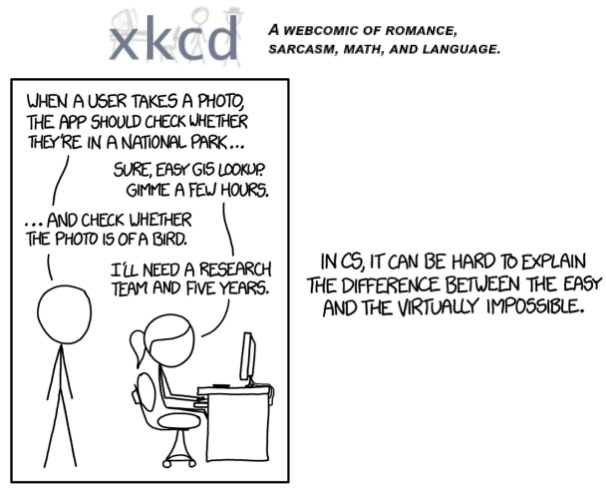

But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "sunflower photos"
1. Use DuckDuckGo to search for images of "forest photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

## Step 1: Download images of sunflowers and non-sunflowers

In [106]:
from fastbook import *
from fastai.vision.widgets import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(search_images_ddg(term, max_images=max_images))


Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [107]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('sunflower photos', max_images=1)
urls[0]

Searching for 'sunflower photos'


'http://publicdomainpictures.net/pictures/20000/velka/sunflower-1106612995957158RJ.jpg'

...and then download a URL and take a look at it:

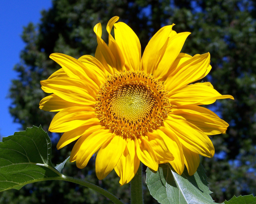

In [108]:
from fastdownload import download_url
dest = 'sunflower.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos":

Searching for 'forest photos'


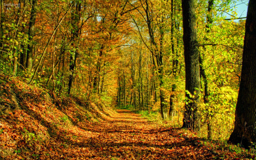

In [109]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "sunflower" and "forest" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [110]:
searches = 'forest','sunflower'
path = Path('sunflower_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} cartoon photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'forest cartoon photo'
Searching for 'sunflower photo'
Searching for 'sunflower sun photo'
Searching for 'sunflower shade photo'
Searching for 'sunflower cartoon photo'


In [111]:
print(path)
searches = 'forest','sunflower'

for imageType in searches:
    print(imageType)
    content = os.listdir(path/imageType)
    for element in content:
        print(element)

sunflower_or_not
forest
a4444fdd-dad1-4014-8d52-c29640eb23be.jpg!d
826b9da7-d2f7-447e-ac24-d716786b02c7.jpg
b6694244-cf01-4fd3-bc70-daa386209719.jpg!d
a2b655ed-c2d6-4b0a-a56a-c340afd93757.jpg
fec25589-bcfa-4f80-a6ae-327e92cc9a56.jpg
653163e5-eaff-4b08-b5b8-04b3fd562ec5.jpg
13b96269-f170-4c03-9054-d64c82580b89.jpg
cbcff3d8-e731-4c10-858c-0ff47cd2570f.jpg
62eccd97-3d3f-4e73-b050-edca9760e362.jpg
b0285095-5cab-4547-8fbb-cac117e7a79f.jpg
ad54889c-bb02-42c4-836d-9a6aaed6f52c.jpg
5352fbdc-751b-410e-9fff-ff92df395199.jpg
7bdc2fc2-a850-4e00-9745-8c0ac369e37c.jpg
21912e5a-5cab-4c42-8ba6-c3b8cff7d118.jpg
a1ac8ed2-aab0-4183-a664-bbd15cf2701c.jpg
df82b470-520b-4c0b-98c8-095e960f853d.jpg
aecc06b1-b81a-42ab-b024-5cd9b9702352.jpg
6e34f144-0249-4be7-a9f7-07d7b0147a80.jpeg
7516f8e1-f699-4c10-aa95-d7da77196ed5.jpg
b9050f1e-523b-4456-bd76-8ad032b0b4f7.jpg
88462d05-c033-4c7b-a17b-97a53c14b628.jpg
28878003-9537-4140-8182-86c00b31f494.jpg
1b056d68-4e4b-4931-ac0d-5e151b4d5521.jpg
e323c763-2aff-43f0-b566-350e

## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [112]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

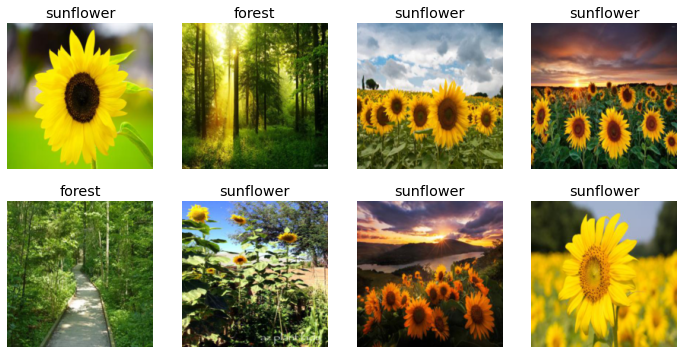

In [113]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=8)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "sunflower" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [114]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.210448,0.000242,0.000000,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.019091,0.000038,0.000000,00:05
1,0.020710,0.000228,0.000000,00:05
2,0.012746,0.000038,0.000000,00:05


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that sunflower we downloaded at the start:

In [115]:
is_sunflower,_,probs = learn.predict(PILImage.create('sunflower.jpg'))
print(f"This is a: {is_sunflower}.")
print(f"Probability it's a sunflower: {probs[0]:.4f}")

This is a: sunflower.
Probability it's a sunflower: 0.0000
